# **Projet python pour la data science / 2024-2025**

Rédigé par:
* ABE Kevin
* DEMGNE Lisa
* Oscar

## **Introduction**

Un accident de la route ou accident de la circulation est entendu comme une collision non voulue, non prévue et mal anticipée d'au moins un engin roulant avec une chose, un animal ou une personne sur une voie publique ou privée ouverte à la circulation.Ils constituent un véritable fléau mondial, causant chaque année des milliers de morts et de blessés. Ces tragédies bouleversent des vies et ont un impact considérable sur la société. En France, la lutte contre ce phénomène est prise en charge au niveau national par la délégation à la sécurité routière, qui se sert des éclairages fourni par un document d'information édité annuellement par l'ONISR (Observatoire National Interministériel de la Sécurité Routière) faisant la synthèse des principales données de l'accidentologie.

Nous nous intéresserons dans le cadre de ce projet à la description de l'accidentologie en France en 2023, ainsi qu'a la prédiction du niveau de gravité d'un accident. Ainsi, ce projet se donne de renseigner sur la fréquence des accidents, le profil des victimes, les caractéristiques des véhicules impliqués, les conditions météorologiques,... et ainsi que les facteurs succeptibles d'influencer le niveau de gravité d'un accident.

In [1]:
!pip install requests
!pip install os
!pip install matplotlib
!pip install pandas 
!pip install plotly
!pip install plotly
!pip install io
!pip install seaborn
!pip install ipywidgets
!pip install tabulate
!pip install ipywidgets 
!pip install tabulate 
!pip install scipy
!pip install numpy 
!pip install IPython

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement os (from versions: none)
ERROR: No matching distribution found for os
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
ERROR: Could not find a version that satisfies the requirement io (from versions: none)
ERROR: No matching distribution found for io
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation 

### *Packages

In [2]:
import requests
import os
import matplotlib.pyplot as plt
import pandas as pd
import plotly
import plotly.express as px
import io
import seaborn as sns
!pip install ipywidgets
!pip install tabulate
import ipywidgets as widgets
from tabulate import tabulate
from scipy.stats import chi2_contingency
import numpy as np
from IPython.display import display


Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


### **I- Importation des bases de données**

Dans cette partie, nous allons importation les bases données qui seront utilisées dans ce projet.
- base des usagers ayant été impliqué dans un accident de circulation en 2023
- base qui donne la description des véhicules impliqués dans un accident de circulation en 2023
- base des lieux où s'est produit l'accident
- base contenant les caractéristiques des accidents.
- base des départements de France



In [3]:
# fonction de téléchargement des données sur les accidents corporels
def telecharge(url_data,filename, path):
    # Vérifie si le dossier 'data' existe, sinon le crée
    if not os.path.exists(path):
        os.makedirs(path)
    #télécharge les données avec l'url
    response = requests.get(url_data)
    if response.status_code == 200:
        file_path = os.path.join(path, filename)
        with open(file_path, 'wb') as file:
            file.write(response.content)
        print(f"Fichier {filename} téléchargé avec succès:{file_path}")
    else:
        print(f"Echec de téléchargement pour {filename}. Statut: {response.status_code}")

# API pour accéder à l'url de téléchargement
url_root="https://www.data.gouv.fr/api/1/datasets/53698f4ca3a729239d2036df/resources/"
urls={
    "usagers-2023.csv":"68848e2a-28dd-4efc-9d5f-d512f7dbe66f",
    "vehicules-2023.csv":"146a42f5-19f0-4b3e-a887-5cd8fbef057b",
    "lieux-2023.csv":"8bef19bf-a5e4-46b3-b5f9-a145da4686bc",
    "caract-2023.csv":"104dbb32-704f-4e99-a71e-43563cb604f2"
}
path='/home/onyxia/Projet-Python-pour-la-Data-Science/data'

for filename, resource_id in urls.items():
    url=url_root+resource_id
    response1=requests.get(url)
    if response1.status_code==200:
        data=response1.json()
        url_data=data['url']
    else:
        print("downloading failed")
    telecharge(url_data,filename,path)


Fichier usagers-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/usagers-2023.csv
Fichier vehicules-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/vehicules-2023.csv
Fichier lieux-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/lieux-2023.csv
Fichier caract-2023.csv téléchargé avec succès:/home/onyxia/Projet-Python-pour-la-Data-Science/data/caract-2023.csv


In [ ]:
# téléchargement de la liste des départements
url_code_dep=f"https://tabular-api.data.gouv.fr/api/resources/e436f772-b05d-47f8-b246-265faab8679f/data/?page=1"
response=requests.get(url_code_dep)
data=response.json()
df_code_dep = pd.DataFrame(data["data"])
df_dep=df_code_dep
for i in range(2,7):
    url_code_dep=f"https://tabular-api.data.gouv.fr/api/resources/e436f772-b05d-47f8-b246-265faab8679f/data/?page={i}"
    response=requests.get(url_code_dep)
    if response.status_code==200:
        data=response.json()
        df_code_dep1 = pd.DataFrame(data["data"])
    else:
        print("downloading failed")
    df_dep=pd.concat([df_dep, df_code_dep1], axis=0)


In [ ]:
df_dep.head()

In [4]:
# base des usagers 
df_usagers = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/usagers-2023.csv", sep = ';')
df_usagers.head()

,Num_Acc,id_usager,id_vehicule,num_veh,place,catu,grav,sexe,an_nais,trajet,secu1,secu2,secu3,locp,actp,etatp
0,202300000001,203 851 184,155 680 557,A01,1,1,4,1,1978.0,5,2,0,-1,-1,-1,-1
1,202300000002,203 851 182,155 680 556,A01,1,1,1,2,1997.0,9,1,0,-1,-1,-1,-1
2,202300000002,203 851 183,155 680 556,A01,10,3,3,1,1997.0,9,0,-1,-1,2,3,1
3,202300000003,203 851 180,155 680 554,B01,1,1,3,1,1987.0,0,2,6,0,0,0,-1
4,202300000003,203 851 181,155 680 555,A01,1,1,1,2,1984.0,0,1,0,0,0,0,-1


In [6]:
# Base des véhicules 
df_vehicules = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/vehicules-2023.csv", sep = ';')
df_vehicules.head()

,Num_Acc,id_vehicule,num_veh,senc,catv,obs,obsm,choc,manv,motor,occutc
0,202300000001,155 680 557,A01,1,30,0,0,5,1,1,NaN
1,202300000002,155 680 556,A01,2,7,0,1,1,1,1,NaN
2,202300000003,155 680 554,B01,1,2,0,2,1,16,1,NaN
3,202300000003,155 680 555,A01,2,7,0,2,2,15,1,NaN
4,202300000004,155 680 551,B01,1,7,0,2,9,2,4,NaN


In [ ]:
# Base des lieux 
df_lieux = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/lieux-2023.csv", sep = ';')
df_lieux.head(5)

In [ ]:
# Base caract
df_caract = pd.read_csv(r"/home/onyxia/Projet-Python-pour-la-Data-Science/data/caract-2023.csv", sep = ';')
df_caract.head()

Nous construisons la base de données qui servira pour la modélisation.

In [ ]:
# fusion des bases de données
df_merge = df_usagers.merge(df_vehicules, on=["Num_Acc","id_vehicule","num_veh"], how="inner") 
df_merge = df_merge.merge(df_lieux, on="Num_Acc", how="inner")
df_merge = df_merge.merge(df_caract, on="Num_Acc", how="inner")

In [ ]:
#supression des variables d'identification
var=["Num_Acc","jour","an","com","adr","lat","long","voie","v1","v2","id_vehicule","num_veh","id_usager","an_nais", "dep"]
Num_acc=df_merge["Num_Acc"]
df_merge.drop(var, axis=1,inplace=True)

# pourcentage des valeurs manquantes par variables 
df_merge.isna().sum()[df_merge.isna().sum()!=0]/len(df_merge)*100

## **II- Analyses descriptives**

### Base USAGERS

Selon le "Guide BAAC 2017" un usager est une personne physique impliquée dans un accident de la circulation en tant que conducteur/passager d'un véhicule ou piéton.

Répartition par sexe : Proportion d'hommes et de femmes impliqués dans les accidents.
Selon "Guide BAAC 2017" 1 = Masculin, 2 = Feminin

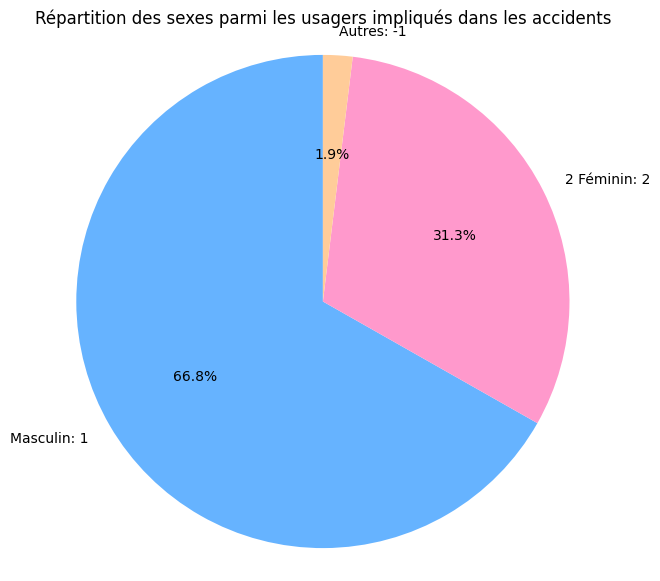

In [5]:
df_usagers['sexe_label'] = df_usagers['sexe'].replace({
    1: 'Masculin: 1', 
    2: '2 Féminin: 2', 
    -1: 'Autres: -1'
})

# Compter la répartition des sexes après remplacement
sexe_counts = df_usagers['sexe_label'].value_counts()

colors = ['#66b3ff', '#ff99cc', '#ffcc99']  # Masculin, Féminin, Autres

# Tracer un diagramme circulaire
plt.figure(figsize=(7, 7))
plt.pie(sexe_counts, labels=sexe_counts.index, autopct='%1.1f%%', startangle=90, colors=colors)
plt.title("Répartition des sexes parmi les usagers impliqués dans les accidents")
plt.axis('equal') 
plt.show()
#La majorité des usagers impliqués dans les accidents sont de sexe masculin, représentant 66,8% du total. 
# Cela suggère que, dans cette population, les hommes sont nettement plus nombreux que les femmes à être impliqués dans des accidents.
# Les femmes représentent 31,3% des usagers impliqués et la catégorie "autres" représente 1,9% des cas, ce qui pourrait inclure des 
# personnes dont le sexe n'est pas précisé ou qui ne s'identifient pas selon les catégories traditionnelles de sexe. 
# Cette proportion est relativement faible, mais elle mérite d'être mentionnée.

Repartition selon l'âge

╒═══════════════╤═══════════╕
│ Statistique   │    Valeur │
╞═══════════════╪═══════════╡
│ Nombre        │ 123191    │
├───────────────┼───────────┤
│ Moyenne       │     38.75 │
├───────────────┼───────────┤
│ Écart-type    │     19.1  │
├───────────────┼───────────┤
│ Min           │      0    │
├───────────────┼───────────┤
│ 25%           │     23    │
├───────────────┼───────────┤
│ 50% (médiane) │     35    │
├───────────────┼───────────┤
│ 75%           │     52    │
├───────────────┼───────────┤
│ Max           │    110    │
╘═══════════════╧═══════════╛
╒═════════════════╤════════════════════╤══════════════════╕
│ Tranche d'âge   │   Nombre d'usagers │   Proportion (%) │
╞═════════════════╪════════════════════╪══════════════════╡
│ [0-9]           │               3504 │             2.79 │
├─────────────────┼────────────────────┼──────────────────┤
│ [10-19]         │              13799 │            10.97 │
├─────────────────┼────────────────────┼──────────────────┤
│ [20-29] 

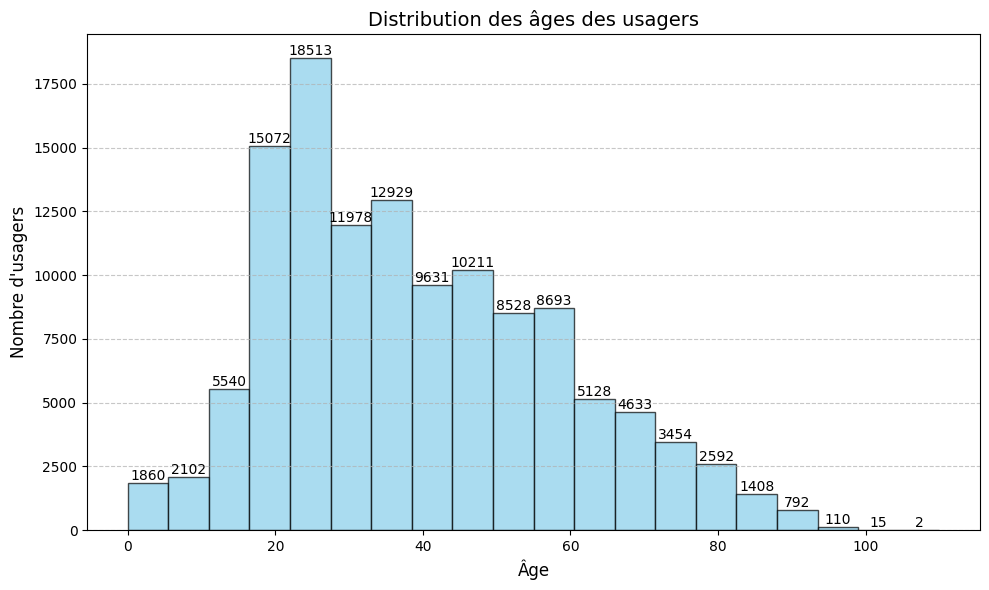

In [6]:
df_usagers['age'] = 2023 - df_usagers['an_nais']
# Calcul des statistiques descriptives
age_stats = df_usagers['age'].describe()

age_summary = pd.DataFrame({
    'Statistique': ['Nombre', 'Moyenne', 'Écart-type', 'Min', '25%', '50% (médiane)', '75%', 'Max'],
    'Valeur': [
        int(age_stats['count']),
        round(age_stats['mean'], 2),
        round(age_stats['std'], 2),
        int(age_stats['min']),
        int(age_stats['25%']),
        int(age_stats['50%']),
        int(age_stats['75%']),
        int(age_stats['max']),
    ]
})
print(tabulate(age_summary, headers='keys', tablefmt='fancy_grid', showindex=False))

# Groupement des âges par tranche de 10 ans
age_bins = pd.cut(df_usagers['age'], bins=range(0, 121, 10), right=False)
age_distribution = age_bins.value_counts().sort_index()

distribution_summary = pd.DataFrame({
    'Tranche d\'âge': [f"[{int(interval.left)}-{int(interval.right - 1)}]" for interval in age_distribution.index],
    'Nombre d\'usagers': age_distribution.values,
    'Proportion (%)': (age_distribution.values / len(df_usagers) * 100).round(2)
})

print(tabulate(distribution_summary, headers='keys', tablefmt='fancy_grid', showindex=False))

# Histogramme
plt.figure(figsize=(10, 6))
n, bins, patches = plt.hist(df_usagers['age'], bins=20, color='skyblue', edgecolor='black', alpha=0.7)

# Ajouter les chiffres au-dessus de chaque barre
for i in range(len(patches)):
    plt.text(patches[i].get_x() + patches[i].get_width() / 2,  # Position X au centre de la barre
             patches[i].get_height(),  # Position Y à la hauteur de la barre
             f'{int(n[i])}',  # Afficher le nombre d'usagers
             ha='center', va='bottom', fontsize=10, color='black')

plt.title('Distribution des âges des usagers', fontsize=14)
plt.xlabel('Âge', fontsize=12)
plt.ylabel('Nombre d\'usagers', fontsize=12)

# Grille et ajustement
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

plt.show()


#La population analysée, composée de 123 191 usagers, présente un âge moyen de 38,75 ans, avec une dispersion modérée (écart-type de 19,1 ans) 
# et une médiane de 35 ans, indiquant que la moitié des individus a cet âge ou moins. La majorité des usagers se situe entre 23 ans (1er quartile) 
# et 52 ans (3e quartile), avec des âges extrêmes allant de 0 à 110 ans, bien que ces valeurs puissent inclure des erreurs ou des cas particuliers.
#  La distribution par tranche d'âge révèle une forte proportion de jeunes (11,2 % entre 10 et 19 ans) et une concentration probable dans les tranches d'âge actif (20-49 ans),
#  tandis que les individus très âgés (100 ans et plus) restent marginaux (0,01 %). Cette structure reflète une population principalement jeune et adulte.

Catégorie d'usagers (catu) : Identification des catégories les plus exposées (conducteurs, passagers, piétons).

/tmp/ipykernel_44272/1411351247.py:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=catu_counts.index,y=catu_percentage.values,palette="viridis")


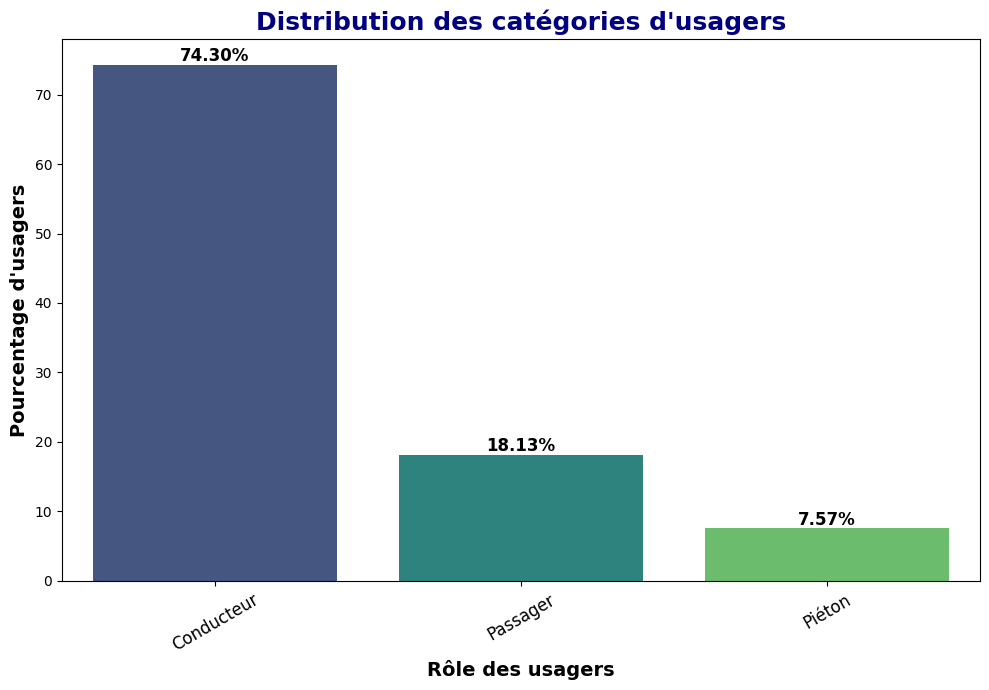

In [7]:
catu_counts = df_usagers['catu'].value_counts()
catu_proportions = df_usagers['catu'].value_counts(normalize=True)

catu_labels = {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}
catu_counts = catu_counts.rename(index=catu_labels)
catu_proportions = catu_proportions.rename(index=catu_labels)

catu_summary = pd.DataFrame({'Fréquence': catu_counts,'Proportion': catu_proportions})
catu_summary['Proportion (%)'] = catu_summary['Proportion'] * 100
catu_summary = catu_summary.rename(columns={'Fréquence': 'Nombre d\'observations'})

# Visualisation
total_count = catu_counts.sum()
catu_percentage = (catu_counts / total_count) * 100  

plt.figure(figsize=(10, 7))
sns.barplot(x=catu_counts.index,y=catu_percentage.values,palette="viridis")

plt.title("Distribution des catégories d'usagers", fontsize=18, weight='bold', color='navy')
plt.xlabel("Rôle des usagers", fontsize=14, weight='bold')
plt.ylabel("Pourcentage d'usagers", fontsize=14, weight='bold')
plt.xticks(rotation=30, fontsize=12)
# Ajouter les valeurs en pourcentages au-dessus des barres
for i, value in enumerate(catu_percentage.values):
    plt.text(i, value + 0.5, f"{value:.2f}%", ha='center', fontsize=12, color='black', weight='bold')
# Ajustement des marges pour éviter le chevauchement
plt.tight_layout()

plt.show()


# On observe que la majorité des personnes impliquées dans des accidents sont des conducteurs(soit 74,3% des usagers), 
# ensuite vient les passagers (18,1%) et enfin les piétons (7.6%). 

Répartition selon la gravité (grav) : Observation de la distribution des niveaux de gravité des accidents.

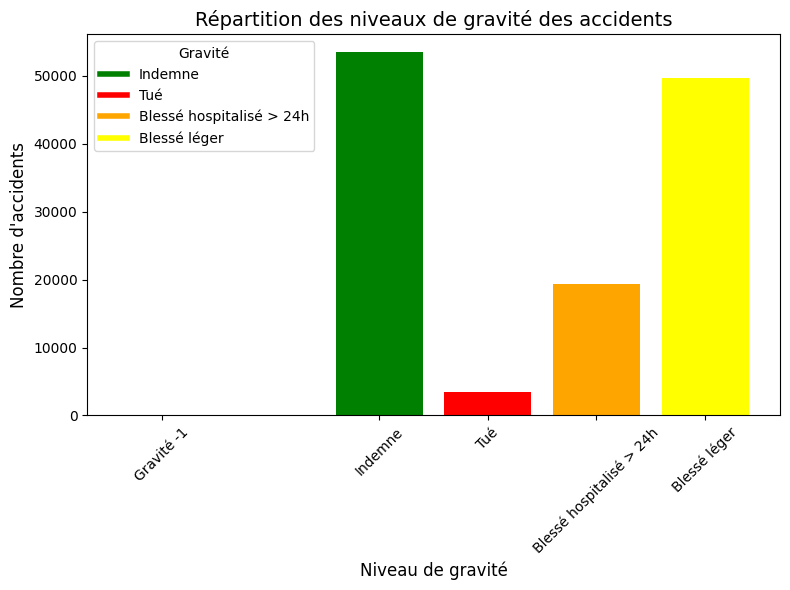

In [ ]:
# Statistiques descriptives 
grav_stats = df_usagers['grav'].value_counts()
grav_percentage = df_usagers['grav'].value_counts(normalize=True)

grav_labels = {1: 'Indemne', 2: 'Tué', 3: 'Blessé hospitalisé > 24h', 4: 'Blessé léger'}

colors = {
    1: 'green',        # Indemne
    2: 'red',          # Tué
    3: 'orange',       # Blessé hospitalisé > 24h
    4: 'yellow'        # Blessé léger
}

# Génération des couleurs pour les barres
bar_colors = [colors.get(i, 'gray') for i in grav_stats.index]

# Création du graphique
plt.figure(figsize=(8, 6))
plt.bar(grav_stats.index, grav_stats.values, color=bar_colors)

# Ajout des titres et des étiquettes
plt.title('Répartition des niveaux de gravité des accidents', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Nombre d\'accidents', fontsize=12)
plt.xticks(grav_stats.index, [grav_labels.get(i, f"Gravité {i}") for i in grav_stats.index], rotation=45)

# Ajout d'une légende
custom_legend = [plt.Line2D([0], [0], color=color, lw=4) for color in colors.values()]
plt.legend(custom_legend, [grav_labels[i] for i in colors.keys()], title="Gravité", fontsize=10)

plt.tight_layout()
plt.show()

#Les résultats montrent que la majorité des usagers impliqués dans les accidents (50919) sont indemnes, ce qui indique que 
# les accidents sont souvent de faible gravité. Aussi, un nombre importante (49603) ont entrainé des blessures légères. 
# Il en ressort également un résultats alarmant selon lequel 19271 des cas d'accidents ont entrainé des blessures graves et nécessitent
# une hospitalisation de plus de 24 heures et 3398 accidents ont entrainé la mort des usagers.  

Analyse de la gravité en fonction du sexe ou de la catégorie d'usager.

<Figure size 1000x600 with 0 Axes>

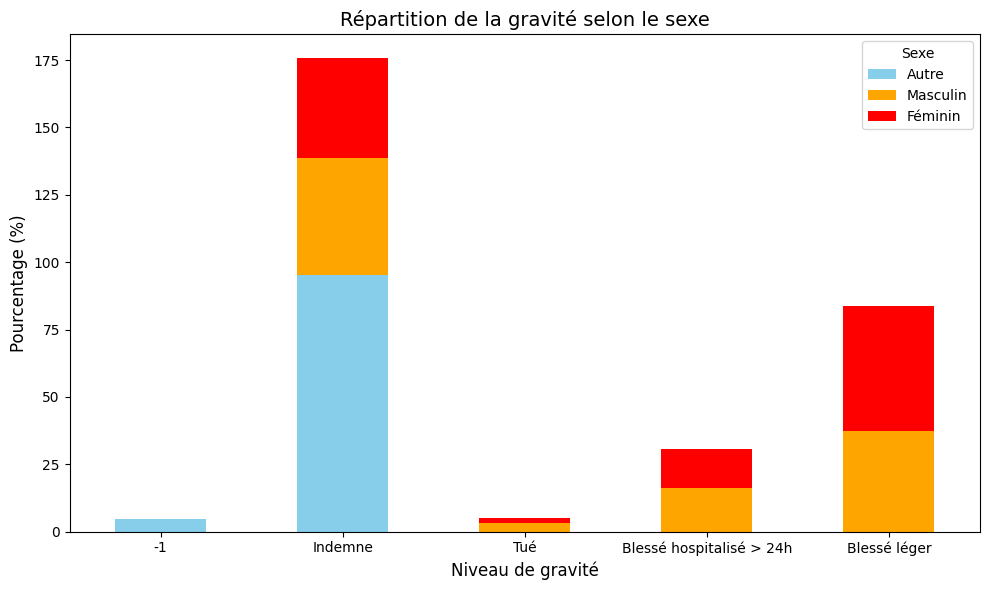

<Figure size 1200x800 with 0 Axes>

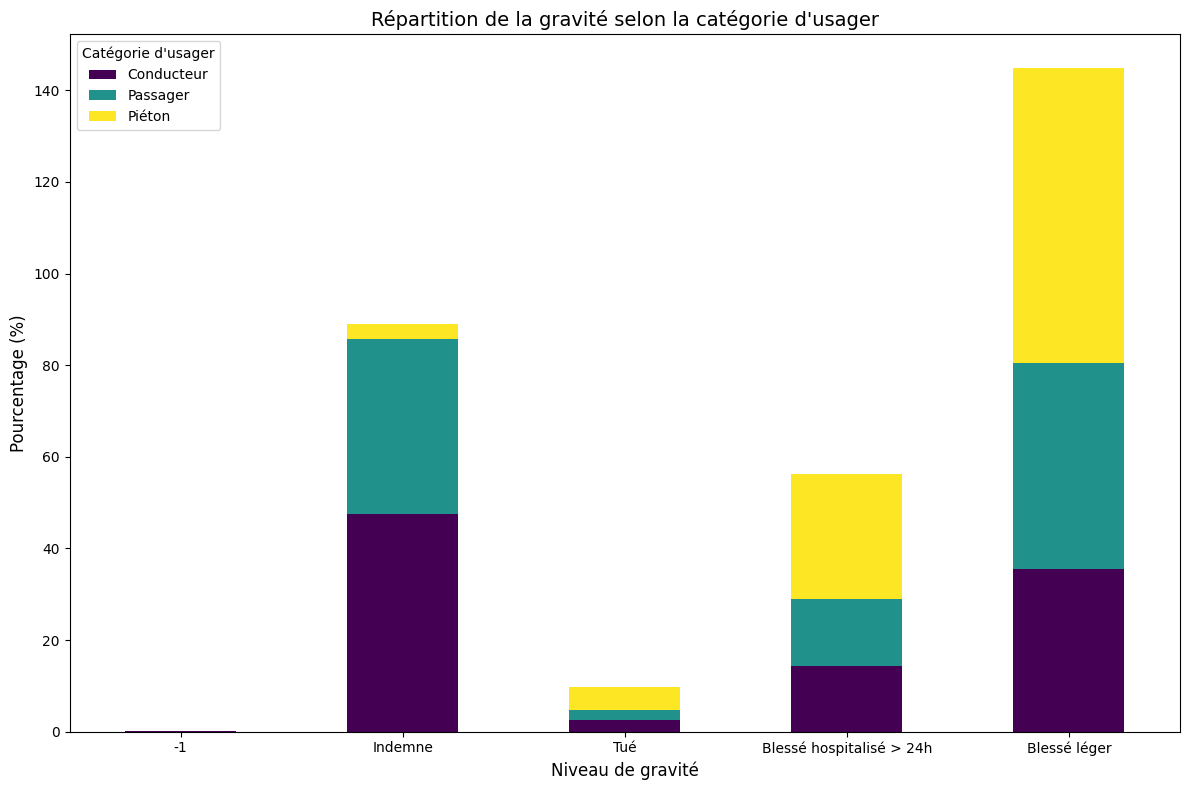

In [5]:
# Dictionnaires pour les libellés
sexe_labels = {1: 'Masculin', 2: 'Féminin', -1: 'Autre'}
catu_labels = {1: 'Conducteur', 2: 'Passager', 3: 'Piéton'}
grav_labels = {1: 'Indemne', 2: 'Tué', 3: 'Blessé hospitalisé > 24h', 4: 'Blessé léger'}

# 1. Répartition de la gravité selon le sexe (en pourcentage)
grav_sexe = pd.crosstab(df_usagers['grav'], df_usagers['sexe'], normalize='columns') * 100
grav_sexe = grav_sexe.rename(index=grav_labels, columns=sexe_labels)

# Visualisation de la gravité en fonction du sexe
plt.figure(figsize=(10, 6))
grav_sexe.index = [grav_labels.get(i, str(i)) for i in grav_sexe.index]  # Remplacer les indices par les libellés
grav_sexe.plot(kind='bar', stacked=True, figsize=(10, 6), color=['skyblue', 'orange', 'red', 'green'])
plt.title('Répartition de la gravité selon le sexe', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.legend(title='Sexe', labels=[sexe_labels.get(x, str(x)) for x in grav_sexe.columns])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# 2. Répartition de la gravité selon la catégorie d’usager (en pourcentage)
grav_usager = pd.crosstab(df_usagers['grav'], df_usagers['catu'], normalize='columns') * 100
grav_usager = grav_usager.rename(index=grav_labels, columns=catu_labels)

# Visualisation de la gravité en fonction de la catégorie d’usager
plt.figure(figsize=(12, 8))
grav_usager.index = [grav_labels.get(i, str(i)) for i in grav_usager.index]  # Remplacer les indices par les libellés
grav_usager.plot(kind='bar', stacked=True, figsize=(12, 8), colormap='viridis')
plt.title('Répartition de la gravité selon la catégorie d\'usager', fontsize=14)
plt.xlabel('Niveau de gravité', fontsize=12)
plt.ylabel('Pourcentage (%)', fontsize=12)
plt.legend(title='Catégorie d\'usager', labels=[catu_labels.get(x, str(x)) for x in grav_usager.columns])
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
 
#La répartition de la gravité selon le sexe met en évidence une surreprésentation des hommes par rapport aux femmes dans la plupart des catégories de gravité.
#  Cependant La catégorie de sexe "Autre" représente la majorité des personnes indemnes.
#  Les femmes, bien qu’impliquées dans les accidents, présentent des proportions plus faibles dans la plupart des catégories de gravité sauf les bléssés légers. 
# Cette différence dans la répartition pourrait être liée à des variations dans les types d'usagers ou les comportements sur la route selon le sexe.

#Le tableau présente la répartition des accidents par gravité selon la catégorie d'usager (conducteur, passager, piéton). 
# Il montre que les conducteurs et passagers sont principalement indemnes ou légèrement blessés, avec respectivement 47,48 % 
# et 38,27 % des conducteurs indemnes. En revanche, les piétons sont plus gravement touchés, avec 64,57 % d'entre eux blessés 
# légèrement et un taux élevé de blessés hospitalisés (27,27 %). Les conducteurs et passagers ont un pourcentage relativement 
# faible de décès (2,61 % et 2,12 %, respectivement), tandis que les piétons représentent 4,98 %. Cette répartition souligne 
# la vulnérabilité des piétons dans les accidents, étant plus susceptibles d'être gravement blessés ou tués, tandis que les 
# conducteurs et passagers sont plus souvent indemnes ou légèrement blessés.

analyse des équipements de sécurité (secu1, secu2)

In [6]:
secu1_labels = {
    1: 'Ceinture',
    2: 'Casque',
    3: 'Dispositif enfants',
    8: 'Non déterminable'
}

secu2_labels = {
    0: 'Aucun équipement',
    4: 'Gilet réfléchissant',
    5: 'Airbag personnel (2/3 RM)',
    6: 'Gants (2/3 RM)',
    7: 'Airbag personnel + Gants (2/3 RM)',
    9: 'Autres équipements'
}
secu3_labels = {
    -1: "Non renseigné",
    0: "Aucun équipement",
    1: "Ceinture",
    2: "Casque",
    3: "Dispositif enfants",
    4: "Gilet réfléchissant",
    5: "Airbag (2RM/3RM)",
    6: "Gants (2RM/3RM)",
    7: "Gants + Airbag (2RM/3RM)",
    8: "Non déterminable",
    9: "Autre"
}
# Mapping des libellés sur le DataFrame
df_usagers['secu1_label'] = df_usagers['secu1'].map(secu1_labels)
df_usagers['secu2_label'] = df_usagers['secu2'].map(secu2_labels)
df_usagers['secu3_label'] = df_usagers['secu3'].map(secu2_labels)

# Création d'un widget pour sélectionner la variable
dropdown = widgets.Dropdown(
    options=['secu1_label', 'secu2_label', 'secu3_label'],
    value='secu1_label',
    description='Variable:',
    disabled=False
)

# Fonction pour afficher le graphique
def plot_security_distribution(variable):
    plt.figure(figsize=(10, 6))
    
    # Calcul des valeurs et des pourcentages
    value_counts = df_usagers[variable].value_counts(normalize=True) * 100
    labels = value_counts.index
    values = value_counts.values
    
    # Création du barplot
    sns.barplot(
        x=labels,
        y=values,
        palette='viridis'
    )
    
    # Ajout des pourcentages sur les barres
    for i, value in enumerate(values):
        plt.text(i, value + 1, f'{value:.2f}%', ha='center', fontsize=12, color='black', weight='bold')
    
    # Titre et labels
    plt.title(f'Distribution des équipements de sécurité - {variable}', fontsize=16)
    plt.xlabel('Dispositif de sécurité', fontsize=14)
    plt.ylabel('Pourcentage d\'utilisation (%)', fontsize=14)
    plt.xticks(rotation=45)
    plt.tight_layout()
    
    # Affichage du graphique
    plt.show()


# Interactivité : afficher le graphique en fonction de la sélection
widgets.interactive(plot_security_distribution, variable=dropdown)

interactive(children=(Dropdown(description='Variable:', options=('secu1_label', 'secu2_label', 'secu3_label'),…

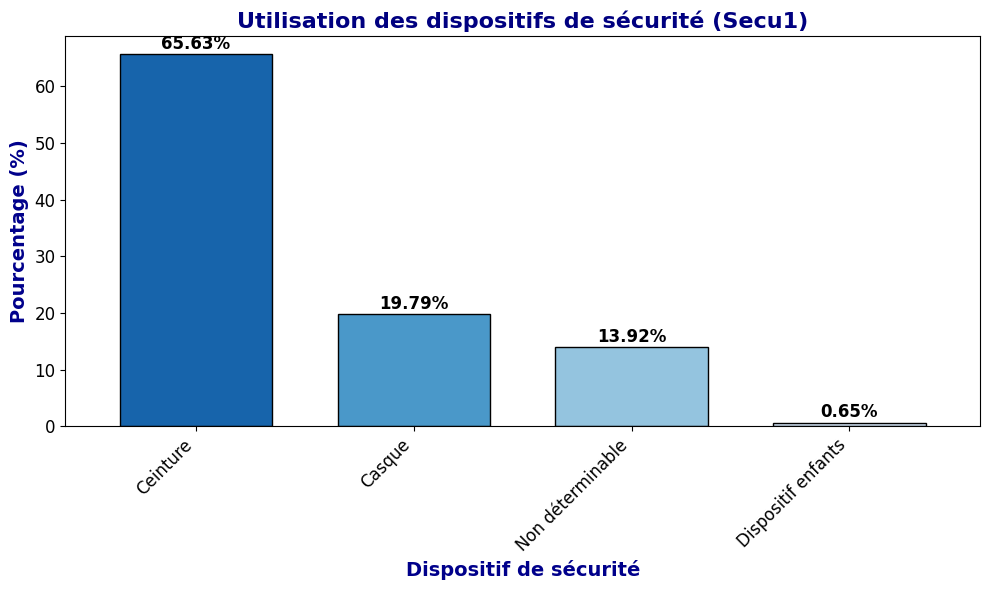


Répartition des équipements de sécurité (secu2) :
+---+-----------------------------------+--------------------+
|   |      Équipement de sécurité       |  Pourcentage (%)   |
+---+-----------------------------------+--------------------+
| 0 |         Aucun équipement          | 74.62384646248495  |
| 1 |          Gants (2/3 RM)           | 19.88096830279524  |
| 2 |        Gilet réfléchissant        | 2.5494850876019792 |
| 3 |     Airbag personnel (2/3 RM)     |  1.92924969907717  |
| 4 |        Autres équipements         | 0.7807275645312292 |
| 5 | Airbag personnel + Gants (2/3 RM) | 0.2357228835094289 |
+---+-----------------------------------+--------------------+


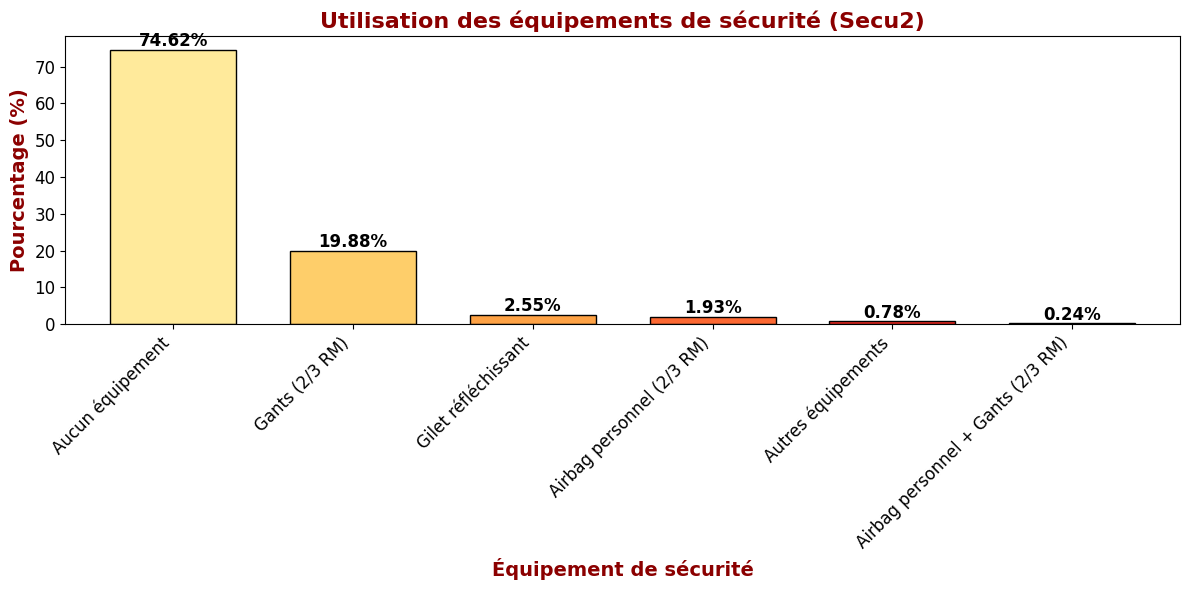


Impact des dispositifs de sécurité (Secu1) sur les accidents graves (en %) :
+---+-------------------------+-------------------+
|   | dispositifs de sécurité |  Pourcentage (%)  |
+---+-------------------------+-------------------+
| 0 |         Casque          | 65.38251862620389 |
| 1 |        Ceinture         | 89.3872965418973  |
| 2 |   Dispositif enfants    | 90.9090909090909  |
| 3 |    Non déterminable     | 83.3204134366925  |
+---+-------------------------+-------------------+


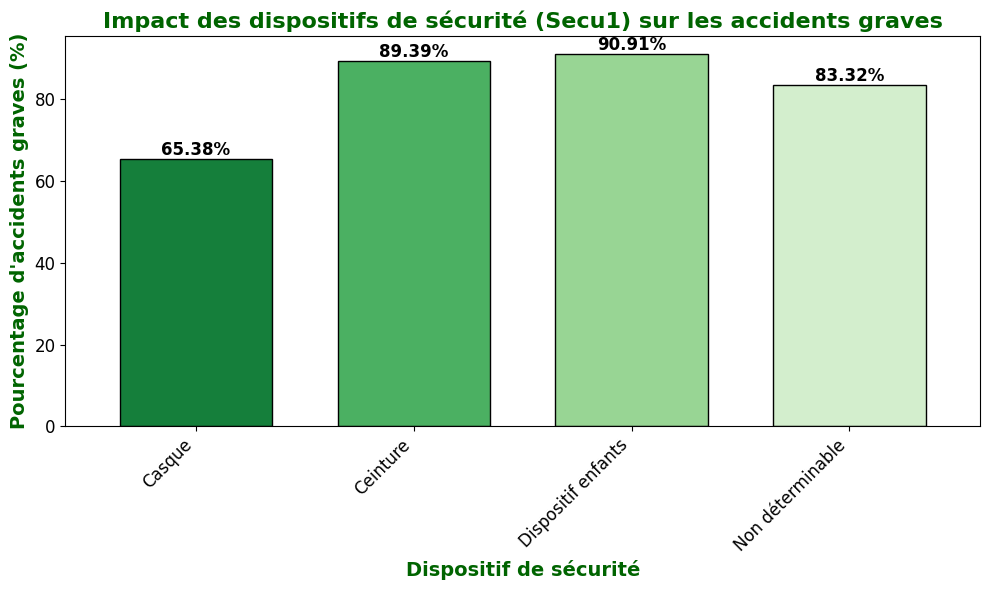


Impact des équipements de sécurité (Secu2) sur les accidents graves (en %) :
+---+-----------------------------------+-------------------+
|   |      Équipement de sécurité       |  Pourcentage (%)  |
+---+-----------------------------------+-------------------+
| 0 |     Airbag personnel (2/3 RM)     | 82.06239168110918 |
| 1 | Airbag personnel + Gants (2/3 RM) | 73.04964539007092 |
| 2 |         Aucun équipement          | 93.3888926227121  |
| 3 |        Autres équipements         | 55.46038543897216 |
| 4 |          Gants (2/3 RM)           | 64.02623612512613 |
| 5 |        Gilet réfléchissant        | 95.01639344262294 |
+---+-----------------------------------+-------------------+


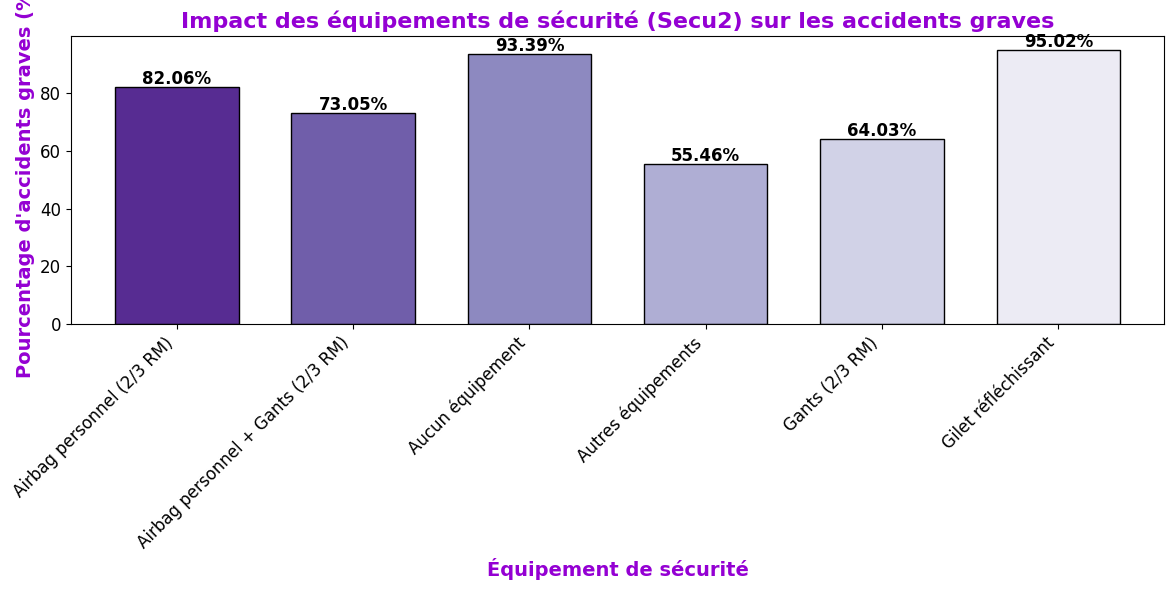

In [19]:
secu1_labels = {
    1: 'Ceinture',
    2: 'Casque',
    3: 'Dispositif enfants',
    8: 'Non déterminable'
}

secu2_labels = {
    0: 'Aucun équipement',
    4: 'Gilet réfléchissant',
    5: 'Airbag personnel (2/3 RM)',
    6: 'Gants (2/3 RM)',
    7: 'Airbag personnel + Gants (2/3 RM)',
    9: 'Autres équipements'
}
secu3_labels = {
    -1: "Non renseigné",
    0: "Aucun équipement",
    1: "Ceinture",
    2: "Casque",
    3: "Dispositif enfants",
    4: "Gilet réfléchissant",
    5: "Airbag (2RM/3RM)",
    6: "Gants (2RM/3RM)",
    7: "Gants + Airbag (2RM/3RM)",
    8: "Non déterminable",
    9: "Autre"
}

# Mapping des libellés sur le DataFrame
df_usagers['secu1_label'] = df_usagers['secu1'].map(secu1_labels)
df_usagers['secu2_label'] = df_usagers['secu2'].map(secu2_labels)
df_usagers['secu3_label'] = df_usagers['secu3'].map(secu2_labels)

df_usagers['accident_grave'] = df_usagers['grav'].apply(lambda x: 1 if x in [1, 4] else 0)

# 1. Étude de l'utilisation des dispositifs de sécurité
secu1_usage = df_usagers['secu1_label'].value_counts(normalize=True) * 100
secu2_usage = df_usagers['secu2_label'].value_counts(normalize=True) * 100
secu3_usage = df_usagers['secu3_label'].value_counts(normalize=True) * 100
#print("\nRépartition des dispositifs de sécurité (secu1) :")
#print(tabulate(secu1_usage.reset_index(), headers=["Dispositif de sécurité", "Pourcentage (%)"], tablefmt="pretty", floatfmt=".2f"))

# Visualisation de l'utilisation des dispositifs de sécurité (secu1)
plt.figure(figsize=(10, 6))
secu1_usage.plot(kind='bar', color=sns.color_palette("Blues_r", len(secu1_usage)), edgecolor='black', width=0.7)

plt.title('Utilisation des dispositifs de sécurité (Secu1)', fontsize=16, weight='bold', color='navy')
plt.xlabel('Dispositif de sécurité', fontsize=14, weight='bold', color='darkblue')
plt.ylabel('Pourcentage (%)', fontsize=14, weight='bold', color='darkblue')

# Ajouter les pourcentages au-dessus des barres
for i, value in enumerate(secu1_usage):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12, color='black', weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print("\nRépartition des équipements de sécurité (secu2) :")
print(tabulate(secu2_usage.reset_index(), headers=["Équipement de sécurité", "Pourcentage (%)"], tablefmt="pretty", floatfmt=".2f"))

# Visualisation de l'utilisation des équipements de sécurité (secu2)
plt.figure(figsize=(12, 6))

secu2_usage.plot(kind='bar', color=sns.color_palette("YlOrRd", len(secu2_usage)), edgecolor='black', width=0.7)

plt.title('Utilisation des équipements de sécurité (Secu2)', fontsize=16, weight='bold', color='darkred')
plt.xlabel('Équipement de sécurité', fontsize=14, weight='bold', color='darkred')
plt.ylabel('Pourcentage (%)', fontsize=14, weight='bold', color='darkred')

# Ajouter les pourcentages au-dessus des barres
for i, value in enumerate(secu2_usage):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12, color='black', weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# 2. Comparaison des taux de blessures graves ou de décès
impact_secu1 = df_usagers.groupby('secu1_label')['accident_grave'].mean() * 100
impact_secu2 = df_usagers.groupby('secu2_label')['accident_grave'].mean() * 100

print("\nImpact des dispositifs de sécurité (Secu1) sur les accidents graves (en %) :")
print(tabulate(impact_secu1.reset_index(), headers=["dispositifs de sécurité", "Pourcentage (%)"], tablefmt="pretty", floatfmt=".2f"))

# Visualisation de l'impact des dispositifs de sécurité sur les accidents graves (secu1)
plt.figure(figsize=(10, 6))
impact_secu1.plot(kind='bar', color=sns.color_palette("Greens_r", len(impact_secu1)), edgecolor='black', width=0.7)
plt.title('Impact des dispositifs de sécurité (Secu1) sur les accidents graves', fontsize=16, weight='bold', color='darkgreen')
plt.xlabel('Dispositif de sécurité', fontsize=14, weight='bold', color='darkgreen')
plt.ylabel('Pourcentage d\'accidents graves (%)', fontsize=14, weight='bold', color='darkgreen')

# Ajouter les pourcentages au-dessus des barres
for i, value in enumerate(impact_secu1):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12, color='black', weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

print("\nImpact des équipements de sécurité (Secu2) sur les accidents graves (en %) :")
print(tabulate(impact_secu2.reset_index(), headers=["Équipement de sécurité", "Pourcentage (%)"], tablefmt="pretty", floatfmt=".2f"))

# Visualisation de l'impact des équipements de sécurité sur les accidents graves (secu2)
plt.figure(figsize=(12, 6))
impact_secu2.plot(kind='bar', color=sns.color_palette("Purples_r", len(impact_secu2)), edgecolor='black', width=0.7)
plt.title('Impact des équipements de sécurité (Secu2) sur les accidents graves', fontsize=16, weight='bold', color='darkviolet')
plt.xlabel('Équipement de sécurité', fontsize=14, weight='bold', color='darkviolet')
plt.ylabel('Pourcentage d\'accidents graves (%)', fontsize=14, weight='bold', color='darkviolet')

# Ajouter les pourcentages au-dessus des barres
for i, value in enumerate(impact_secu2):
    plt.text(i, value + 1, f"{value:.2f}%", ha='center', fontsize=12, color='black', weight='bold')

plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()



In [ ]:
## Répartition des dispositifs de sécurité (Secu1 et Secu2)

#En examinant la répartition des dispositifs de sécurité secu1, on constate que la ceinture 
# de sécurité est l'équipement le plus fréquemment utilisé, avec 65,63 % des usagers. 
# Le casque suit avec 19,79 %, tandis que les dispositifs pour enfants représentent 
# une part marginale, à 0,65 %. Une proportion non négligeable (13,92 %) des équipements n'est pas déterminée,
#  ce qui pourrait indiquer un manque de données ou d'informations sur certains usagers.

#Pour secu2, une majorité (74,62 %) des usagers impliqués dans les accidents ne portaient aucun 
# équipement spécifique. Parmi ceux qui portaient des équipements, les gants (2/3 RM) sont 
# les plus courants (19,88 %), suivis des gilets réfléchissants (2,54 %) et
# des airbags personnels (2/3 RM) (1,93 %). Les autres équipements et 
# les combinaisons airbag personnel + gants (2/3 RM) représentent des proportions plus faibles (0,78 % et 0,23 %, respectivement).


## Impact des dispositifs de sécurité sur la gravité des accidents

#L'analyse laisse croire à une relation entre l'utilisation des dispositifs de sécurité (secu1) 
# et la gravité des accidents. Les usagers portant des dispositifs pour enfants enregistrent
#  le pourcentage le plus élevé d'accidents graves à 90,91 %, suivi 
# par ceux portant la ceinture de sécurité (89,39 %). Les usagers avec des équipements non déterminables 
# enregistrent également un impact élevé (83,32 %), tandis que ceux portant un casque présentent un pourcentage moindre (65,38 %).

#En ce qui concerne les équipements spécifiques (secu2), les usagers portant des gilets réfléchissants (95,02 %) présentent le pourcentage
#d'accidents le plus élevé, suivi par ceux ne portant aucun équipement(93,39 %) . 
# À l'inverse, les usagers portant des gants (2/3 RM) et des airbags personnels + gants enregistrent des impacts plus modérés, à 64,03 % et 73,05 %, respectivement. 
#Enfin, ceux portant d'autres équipements affichent le pourcentage le plus faible d'accidents graves (55,46 %), indiquant une meilleure protection potentielle.

Analyse des trajets

In [ ]:
trajet_labels = {
    0: 'Non renseigné',
    1: 'Domicile-travail',
    2: 'Domicile-école',
    3: 'Courses-achats',
    4: 'Utilisation professionnelle',
    5: 'Promenade-loisirs',
    9: 'Autre'
}

df_usagers['trajet_label'] = df_usagers['trajet'].map(trajet_labels)

# Calcul des fréquences et proportions
trajet_counts = df_usagers['trajet_label'].value_counts()
trajet_proportions = df_usagers['trajet_label'].value_counts(normalize=True) * 100

trajet_summary = pd.DataFrame({
    'Fréquence': trajet_counts,
    'Proportion (%)': trajet_proportions
}).sort_values(by='Fréquence', ascending=False)

print("\nStatistiques descriptives de la variable 'trajet' :")
print(tabulate(trajet_summary.reset_index(), headers=["Type de trajet", "Fréquence", "Proportion (%)"], tablefmt="pretty", floatfmt=".2f"))

# Distribution des types de trajets
plt.figure(figsize=(12, 7))
sns.barplot(x=trajet_counts.values, y=trajet_counts.index, palette='coolwarm_r')  # Palette inversée

plt.title("Distribution des types de trajets liés aux accidents", fontsize=16, fontweight='bold', color='darkblue')
plt.xlabel("Nombre d'accidents", fontsize=14, fontweight='bold', color='green')
plt.ylabel("Type de trajet", fontsize=14, fontweight='bold', color='green')
plt.xticks(fontsize=12, color='purple')
plt.yticks(fontsize=12, color='purple')
plt.tight_layout()
plt.show()


#Les statistiques montrent que les promenades-loisirs dominent les motifs de déplacement des usagers impliqués dans des accidents,
#  représentant 37,42 %, suivies des trajets non renseignés (27,01 %).
#  Les trajets domicile-travail (13,36 %) et utilisation professionnelle (8,92 %) révèlent l'importance des déplacements liés à l'activité 
# professionnelle, totalisant 22,28 %, et pointent des enjeux spécifiques comme les risques associés aux heures de pointe, au stress, 
# et à la fatigue. Les trajets domicile-école (2,42 %) et les déplacements pour courses-achats (2,92 %) ont une contribution moindre.

Analyse descriptive des localisations, actions et états des piétons

In [ ]:
locp_labels = {
    0: 'Sans objet',
    1: 'A + de 50 m du passage piéton',
    2: 'A - de 50 m du passage piéton',
    3: 'Sans signalisation lumineuse',
    4: 'Avec signalisation lumineuse',
    5: 'Trottoir',
    6: 'Sur accotement ou BAU',
    7: 'Sur contre-allée',
    8: 'Inconnue'
}                                                                                                                                  
actp_labels = {
    '-1': 'Non renseigné',
    '0': 'Sans objet',
    '1': 'Sens du véhicule heurtant',
    '2': 'Sens inverse du véhicule heurtant',
    '3': 'Traversant',
    '4': 'Masqué',
    '5': 'Jouant-courant',
    '6': 'Avec animal',
    '7': 'Quitte l arrêt du TC',
    '8': 'Accède à l arrêt du TC',
    '9': 'Autre',
    'A': 'Monte ou descend de son véhicule', 
    'B': 'Inconnu'  
}

etatp_labels = {
    0: 'Sans objet',
    1: 'Seul',
    2: 'Accompagé',
    3: 'En groupe'
}


# Appliquer les mappings aux colonnes
df_usagers['locp_label'] = df_usagers['locp'].map(locp_labels)
df_usagers['actp_label'] = df_usagers['actp'].map(actp_labels)
df_usagers['etatp_label'] = df_usagers['etatp'].map(etatp_labels)

# Analyse descriptive : Fréquences et proportions
def summarize_variable(column, label):
    counts = df_usagers[column].value_counts()
    proportions = df_usagers[column].value_counts(normalize=True) * 100
    summary = pd.DataFrame({'Fréquence': counts, 'Proportion (%)': proportions})
    print(f"\nStatistiques descriptives pour {label} :")
    print(tabulate(summary, headers=["Catégorie", "Fréquence_d_observation", "Proportion (%)"], tablefmt="pretty", floatfmt=".2f"))
    return summary

locp_summary = summarize_variable('locp_label', 'Localisation du piéton')
actp_summary = summarize_variable('actp_label', 'Action du piéton')
etatp_summary = summarize_variable('etatp_label', 'État du piéton')

# Visualisations avec améliorations
def plot_distribution(summary, title, ylabel):
    plt.figure(figsize=(12, 7))
    sns.barplot(x=summary['Fréquence'], y=summary.index, palette='magma')  # Utilisation de la palette 'magma' pour une jolie couleur
    plt.title(title, fontsize=16, fontweight='bold', color='darkblue')
    plt.xlabel("Nombre d'accidents", fontsize=14, fontweight='bold', color='green')
    plt.ylabel(ylabel, fontsize=14, fontweight='bold', color='green')
    plt.xticks(fontsize=12, color='purple')
    plt.yticks(fontsize=12, color='purple')
    plt.tight_layout()
    plt.show()

plot_distribution(locp_summary, "Distribution de la localisation des piétons", "Localisation")
plot_distribution(actp_summary, "Distribution des actions des piétons", "Action")
plot_distribution(etatp_summary, "Distribution de l'état des piétons", "État")

# Analyse croisée (Localisation vs Action)
cross_tab = pd.crosstab(df_usagers['locp_label'], df_usagers['actp_label'], normalize='index') * 100
cross_tab = cross_tab.fillna(0)  # Remplacer NaN par 0

plt.figure(figsize=(12, 8))
sns.heatmap(cross_tab, annot=True, fmt=".1f", cmap='coolwarm', cbar_kws={'label': 'Pourcentage'})
plt.title("Croisement entre localisation et action des piétons", fontsize=16)
plt.xlabel("Action du piéton", fontsize=14)
plt.ylabel("Localisation du piéton", fontsize=14)
plt.tight_layout()
plt.show()

In [ ]:
#### Localisation du piéton (locp_label) :
#La majorité des piétons (84,5 %) se trouvent dans des zones sans objet de localisation précise. Parmi les autres catégories, 
# la majorité se situe à plus de 50 mètres d'un passage piéton (5,3 %) et à moins de 50 mètres (3,2 %). 
# La signalisation lumineuse est présente dans seulement 2,5 % des cas, et un peu plus de 2 % des piétons se trouvent dans des zones 
# à plus de 50 mètres du passage piéton. La localisation précise de l'accident est inconnue dans moins de 1 % des cas, et seules de rares 
# observations concernent des piétons sur des trottoirs (1,4 %) ou sur des accotements (0,5 %).
##########

#### Action du piéton (actp_label) :
#La majorité des piétons (83,8 %) sont dans une situation où l'action est considérée comme "sans objet". 
# Les actions les plus fréquentes sont les piétons traversant (11,9 %) ou des actions considérées comme "autres" (1,1 %). 
# Les cas où le piéton est heurté dans le sens du véhicule sont relativement moins fréquents (1 %), tout comme les situations où
#  il se trouve dans le sens inverse du véhicule heurtant (0,5 %). D'autres actions comme "jouant-courant", "avec animal" ou "masqué" 
# sont très peu fréquentes, avec des proportions inférieures à 1 %, et les cas où le piéton monte ou descend de son véhicule ou accède 
# à un arrêt de transport en commun sont rares (moins de 0,2 %).
##########

#### État du piéton (etatp_label) :
# La grande majorité des piétons sont seuls lors de l'accident (75,2 %), tandis qu'une proportion importante est accompagnée (20,7 %). 
# Les cas où le piéton est en groupe sont beaucoup moins fréquents, représentant seulement 4,1 % des observations.

####################Croisements 
#Les résultats montrent une tendance générale où la majorité des piétons traversent la rue de manière traversante,
#avec une gande proportion d'actions marquées par l'absence de signalisation ou l'absence de comportement spécifique ("Sans objet").
#Les localisations près des passages piétons montrent une plus grande tendance à traverser de manière traversante, mais des comportements
#tels que "Sens du véhicule heurtant" ou "Autre" sont plus fréquents dans des zones où la signalisation lumineuse ou les trottoirs sont moins présents.

#Il semble aussi qu'une partie des actions liées aux transports en commun ("Accède à l’arrêt du TC", "Quitte l’arrêt du TC") 
#soit relativement faible, bien que certaines localisations, comme "Inconnue" et "Sur accotement ou BAU", montrent une certaine
#variété dans les actions des piétons.

Tableau croisé dynamique pour observer les relations entre les variables

In [ ]:
#Matrice de corrélation
col_a_exclu = ['Num_Acc','an_nais']
df_usagers_col_a_exclu = df_usagers.drop(columns=col_a_exclu)
df_numeric = df_usagers_col_a_exclu.select_dtypes(include=['number'])
corr_USAGERS = df_numeric.corr(method="pearson")

plt.figure(figsize=(10, 8))
sns.heatmap(corr_USAGERS, annot=True, cmap='coolwarm', fmt='.2f', 
            xticklabels=corr_USAGERS.columns, yticklabels=corr_USAGERS.columns)

plt.title("Matrice de Corrélation des Variables Usagers")
plt.show()

#Selon le tableau de corrélation les variables couples de variables fortement corrélées sont: (place, catu), (place,locp), (place,etatp), (catu,etatp) et (locp,etatp)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import ipywidgets as widgets
from IPython.display import display

# Sélection des variables numériques
df_usagers_col_a_exclu = df_usagers.drop(columns=col_a_exclu)
df_numeric = df_usagers_col_a_exclu.select_dtypes(include=['number'])

# Création du widget Dropdown
variable_selector = widgets.Dropdown(
    options=df_numeric.columns.tolist(),
    description='Variable:',
    disabled=False
)

# Fonction pour afficher le boxplot
def show_boxplot(variable):
    # Vérifier si la variable existe dans le DataFrame
    if variable in df_numeric.columns:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        # Créer un boxplot avec une couleur personnalisée et une taille de boîte ajustée
        sns.boxplot(x=df_usagers[variable], 
                    color='lightcoral', 
                    width=0.5,          
                    fliersize=7,        
                    linewidth=2,        
                    whis=1.5)           

        plt.title(f'Boxplot de {variable}', fontsize=18, fontweight='bold')

        plt.xlabel(variable, fontsize=14)
        plt.ylabel('Valeur', fontsize=14)

        # Afficher la grille pour rendre les graphes plus lisibles
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Personnaliser la couleur des axes et ajouter un fond doux
        plt.gca().set_facecolor('whitesmoke')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Afficher le graphique
        plt.show()
    else:
        print("La variable spécifiée n'existe pas dans les données.")

# Affichage du widget pour permettre l'interaction
display(variable_selector)

# Lier le widget avec la fonction de boxplot
widgets.interactive(show_boxplot, variable=variable_selector)


In [ ]:
col_a_exclu = ['Num_Acc','an_nais','sexe']
df_usagers_col_a_exclu = df_usagers.drop(columns=col_a_exclu)

df_numeric = df_usagers_col_a_exclu.select_dtypes(include=['number'])

variable_selector = widgets.Dropdown(
    options=df_numeric.columns.tolist(),
    description='Variable:',
    disabled=False
)

# Fonction pour afficher le boxplot
def show_boxplot(variable):
    # Vérifier si la variable existe dans le DataFrame
    if variable in df_numeric.columns:
        plt.figure(figsize=(10, 6))
        sns.set(style="whitegrid")
        # Créer un boxplot avec une couleur personnalisée et une taille de boîte ajustée
        sns.boxplot(x=df_usagers[variable], 
                    color='lightcoral', 
                    width=0.5,          
                    fliersize=7,        
                    linewidth=2,        
                    whis=1.5)           

        plt.title(f'Boxplot de {variable}', fontsize=18, fontweight='bold')

        plt.xlabel(variable, fontsize=14)
        plt.ylabel('Valeur', fontsize=14)

        # Afficher la grille pour rendre les graphes plus lisibles
        plt.grid(True, axis='y', linestyle='--', alpha=0.7)

        # Personnaliser la couleur des axes et ajouter un fond doux
        plt.gca().set_facecolor('whitesmoke')
        plt.xticks(fontsize=12)
        plt.yticks(fontsize=12)

        # Afficher le graphique
        plt.show()

    else:
        print("La variable spécifiée n'existe pas dans les données.")

# Lier le widget avec la fonction de boxplot
widgets.interactive(show_boxplot, variable=variable_selector)



# Description de la base vehicule

In [7]:
#Sens de circulation 
senc_labels = {
    '-1': '-1 Non renseigné',
    0: '0 Inconnu',
    1: '1 PK ou PR ou numéro d\'adresse postale croissant',
    2: '2 PK ou PR ou numéro d\'adresse postale décroissant',
    3: '3 Absence de repère'
}
#obstacles_fixes_heurte
obs_labels = {
    '-1': "Non renseigné",
    0: "Sans objet",
    1: "Véhicule en stationnement",
    2: "Arbre",
    3: "Glissière métallique",
    4: "Glissière béton",
    5: "Autre glissière",
    6: "Bâtiment, mur, pile de pont",
    7: "Support de signalisation verticale ou poste d’appel d’urgence",
    8: "Poteau",
    9: "Mobilier urbain",
    10: "Parapet",
    11: "Ilot, refuge, borne haute",
    12: "Bordure de trottoir",
    13: "Fossé, talus, paroi rocheuse",
    14: "Autre obstacle fixe sur chaussée",
    15: "Autre obstacle fixe sur trottoir ou accotement",
    16: "Sortie de chaussée sans obstacle",
    17: "Buse – tête d’aqueduc"
}
#Catégorie du véhicule
catv_labels = {
    0: "Indéterminable",
    1: "Bicyclette",
    2: "Cyclomoteur <50cm3",
    3: "Voiturette (Quadricycle à moteur carrossé) (anciennement 'voiturette ou tricycle à moteur')",
    4: "Référence inutilisée depuis 2006 (scooter immatriculé)",
    5: "Référence inutilisée depuis 2006 (motocyclette)",
    6: "Référence inutilisée depuis 2006 (side-car)",
    7: "VL seul",
    8: "Référence inutilisée depuis 2006 (VL + caravane)",
    9: "Référence inutilisée depuis 2006 (VL + remorque)",
    10: "VU seul 1,5T <= PTAC <= 3,5T avec ou sans remorque (anciennement VU seul 1,5T <= PTAC <= 3,5T)",
    11: "Référence inutilisée depuis 2006 (VU (10) + caravane)",
    12: "Référence inutilisée depuis 2006 (VU (10) + remorque)",
    13: "PL seul 3,5T <PTCA <= 7,5T",
    14: "PL seul > 7,5T",
    15: "PL > 3,5T + remorque",
    16: "Tracteur routier seul",
    17: "Tracteur routier + semi-remorque",
    18: "Référence inutilisée depuis 2006 (transport en commun)",
    19: "Référence inutilisée depuis 2006 (tramway)",
    20: "Engin spécial",
    21: "Tracteur agricole",
    30: "Scooter < 50 cm3",
    31: "Motocyclette > 50 cm3 et <= 125 cm3",
    32: "Scooter > 50 cm3 et <= 125 cm3",
    33: "Motocyclette > 125 cm3",
    34: "Scooter > 125 cm3",
    35: "Quad léger <= 50 cm3 (Quadricycle à moteur non carrossé)",
    36: "Quad lourd > 50 cm3 (Quadricycle à moteur non carrossé)",
    37: "Autobus",
    38: "Autocar",
    39: "Train",
    40: "Tramway",
    41: "3RM <= 50 cm3",
    42: "3RM > 50 cm3 <= 125 cm3",
    43: "3RM > 125 cm3",
    50: "EDP à moteur",
    60: "EDP sans moteur",
    80: "VAE",
    99: "Autre véhicule"
}
#Obstacle mobile heurté
obsm_labels = {
    '-1': "Non renseigné",
    0: "Aucun",
    1: "Piéton",
    2: "Véhicule",
    4: "Véhicule sur rail",
    5: "Animal domestique",
    6: "Animal sauvage",
    9: "Autre"
}
#point_de_choc_initial
choc_labels = {
    '-1': "Non renseigné",
    0: "Aucun",
    1: "Avant",
    2: "Avant droit",
    3: "Avant gauche",
    4: "Arrière",
    5: "Arrière droit",
    6: "Arrière gauche",
    7: "Côté droit",
    8: "Côté gauche",
    9: "Chocs multiples (tonneaux)"
}
#manoeuvre_principale_avant_accident
manv_labels = {
    '-1': "Non renseigné",
    0: "Inconnue",
    1: "Sans changement de direction",
    2: "Même sens, même file",
    3: "Entre 2 files",
    4: "En marche arrière",
    5: "A contresens",
    6: "En franchissant le terre-plein central",
    7: "Dans le couloir bus, dans le même sens",
    8: "Dans le couloir bus, dans le sens inverse",
    9: "En s’insérant",
    10: "En faisant demi-tour sur la chaussée"
}
#type_motorisation_vehicule
motor_labels = {
    '-1': "Non renseigné",
    0: "Inconnue",
    1: "Hydrocarbures",
    2: "Hybride électrique",
    3: "Electrique",
    4: "Hydrogène",
    5: "Humaine",
    6: "Autre"
}

In [8]:
#Pourcentage de valeurs manquantes pour chaque variable
missing_percentage = (df_vehicules.isnull().sum() / len(df_vehicules)) * 100
print("Pourcentage de valeurs manquantes par variable :")
print(missing_percentage)

Pourcentage de valeurs manquantes par variable :
Num_Acc         0.000000
id_vehicule     0.000000
num_veh         0.000000
senc            0.000000
catv            0.000000
obs             0.000000
obsm            0.000000
choc            0.000000
manv            0.000000
motor           0.000000
occutc         99.104557
dtype: float64


In [9]:
# Suppression de la variable 'occutc' car elle a 99% de variables manquantes
df_vehicules = df_vehicules.drop(columns=['occutc'])

In [10]:
mapping_dict = {
    "senc": senc_labels,
    "catv": catv_labels,
    "obs": obs_labels,
    "choc": choc_labels,
    "obsm": obsm_labels,
    "manv": manv_labels,
    "motor": motor_labels,
}
# Application du mapping
for column, mapping in mapping_dict.items():
    if column in df_vehicules.columns:  # Vérifie si la colonne existe dans le DataFrame
        df_vehicules[column] = df_vehicules[column].map(mapping)


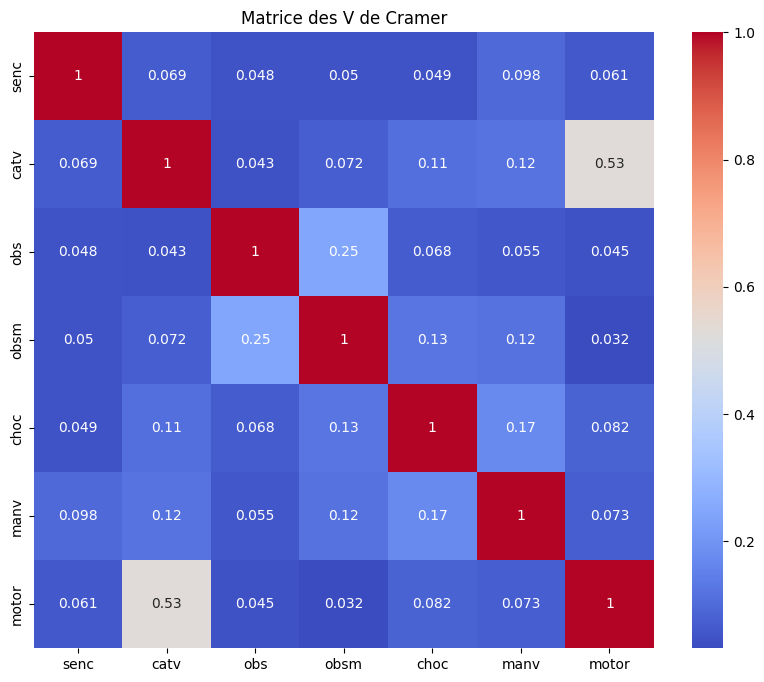

In [20]:
# Matrice des V de Cramer
# Function to calculate Cramer's V
def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    return np.sqrt(phi2 / min(k-1, r-1))

colonnes_a_inclure = ["senc", "catv", "obs", "obsm", "choc", "manv", "motor"]
#Créer un DataFrame vide pour la matrice V de Cramer
cramers_v_matrix = pd.DataFrame(index=colonnes_a_inclure, columns=colonnes_a_inclure)

# Calculer les V de Cramer pour chaque paire de colonnes
for col1 in colonnes_a_inclure:
    for col2 in colonnes_a_inclure:
        cramers_v_matrix.loc[col1, col2] = cramers_v(df_vehicules[col1], df_vehicules[col2])

# Convertir la matrice en valeurs numériques
cramers_v_matrix = cramers_v_matrix.astype(float)

plt.figure(figsize=(10, 8))
sns.heatmap(cramers_v_matrix, annot=True, cmap='coolwarm', cbar=True)
plt.title("Matrice des V de Cramer")
plt.show()


In [ ]:
#Cette matrice des V de Cramer représente la force des associations entre les variables catégoriques nominales de ma base. 
#La matrice des V de Cramer montre que la majorité des relations entre les variables sont faiblement associées (𝑉<0.1), indiquant 
# peu de dépendance entre elles et suggérant que chaque variable apporte des informations distinctes. Une exception notable est 
# l’association modérée entre motor et catv (V=0.53), ce qui suggère que le type de motorisation d’un véhicule est fortement lié à 
# sa catégorie. Une autre relation modérée est observée entre obs et obsm (V=0.25), probablement parce que ces deux variables sont 
# liées à des aspects similaires de l’observation ou de la manœuvre. Ces résultats confirment la pertinence des variables pour une 
# analyse plus approfondie, tout en indiquant que seules quelques-unes sont fortement liées.

In [ ]:
# Fonction pour tracer la distribution d'une variable catégorielle
def plot_distribution(column):
    # Description des colonnes
    if column == "senc":
        title = "Distribution de 'Sens de circulation'"
        xlabel = "Sens de circulation"
    elif column == "catv":
        title = "Distribution de 'Catégorie de véhicule'"
        xlabel = "Catégorie de véhicule"
    elif column == "obs":
        title = "Distribution de 'Observation'"
        xlabel = "Observation"
    elif column == "obsm":
        title = "Distribution de 'Manœuvre observée'"
        xlabel = "Manœuvre observée"
    elif column == "choc":
        title = "Distribution de 'Type de choc'"
        xlabel = "Type de choc"
    elif column == "manv":
        title = "Distribution de 'Manœuvre de véhicule'"
        xlabel = "Manœuvre de véhicule"
    elif column == "motor":
        title = "Distribution de 'Type de motorisation'"
        xlabel = "Type de motorisation"
    else:
        title = f"Distribution de la variable '{column}'"
        xlabel = column

    # Création du graphique
    plt.figure(figsize=(10, 6))
    ax = sns.countplot(x=df_vehicules[column], palette='viridis')
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel("Fréquence")
    plt.xticks(rotation=45)
    
    # Ajouter les chiffres sur la plus longue barre
    max_height = max([p.get_height() for p in ax.patches])  # Hauteur de la barre la plus longue
    for p in ax.patches:
        # Affichage du texte au-dessus de la barre
        ax.annotate(f'{int(p.get_height())}', 
                    (p.get_x() + p.get_width() / 2., p.get_height()), 
                    ha='center', va='center', 
                    fontsize=10, color='black', 
                    xytext=(0, 5), textcoords='offset points')
    
    plt.show()


   # Liste des colonnes à inclure
   colonnes_a_inclure = ["senc", "catv", "obs", "obsm", "choc", "manv", "motor"]

   # Créer un widget dropdown pour sélectionner une colonne
   dropdown = widgets.Dropdown(
       options=colonnes_a_inclure,
       description='Variable:',
   )

   # Créer un widget interactif pour afficher le graphique
   output = widgets.interactive_output(plot_distribution, {'column': dropdown})

   # Afficher le dropdown et le graphique
   display(dropdown, output)

Dropdown(description='Variable:', options=('senc', 'catv', 'obs', 'obsm', 'choc', 'manv', 'motor'), value='sen…

Output()

In [ ]:
# ajout du libellé des départements

df_code_dep=df_dep[["DEP","LIBELLE"]]
#df_code_com=df_com[["COM","LIBELLE"]]
df_merge=pd.merge(left=df_merge, right=df_code_dep,left_on="dep", right_on="DEP", how="left")
#database=pd.merge(left=df_merge, right=df_code_com,left_on="com", right_on="COM", how="left")
database=df_merge.drop(["DEP"], axis=1)
database.info()

In [ ]:
print(f"la base usagers a {df_usagers.shape[0]} observations et {df_usagers.shape[1]} variables.")

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
grav_dict={-1:"Non renseigné",1:'Indemne',2:"Tué",3:'Bléssé hospitalisé',4:'Blessé leger'}
grav_nv=df_usagers['grav'].replace(grav_dict)
grav_prct=(grav_nv.value_counts()/df_usagers.shape[0])*100
grav_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Gravité de l'accident")
plt.ylabel("percentage(%)")

plt.subplot(1,2,2)
catu_dict={1:"Conducteur",2:"Passager",3:"Piéton"}
catu_nv=df_usagers['catu'].replace(catu_dict)
catu_prct=(catu_nv.value_counts()/df_usagers.shape[0])*100
catu_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Catégorie d'usager")
plt.ylabel("percentage(%)")


In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1,2,1)
sexe_dict={1:"Homme",2:"Femme"}
sexe_nv=df_usagers['sexe'].replace(sexe_dict)
sexe_prct=(sexe_nv.value_counts()/df_usagers.shape[0])*100
sexe_prct.plot(kind="bar")
plt.xticks(rotation=45)
plt.xlabel("Sexe")
plt.ylabel("percentage(%)")


plt.subplot(1,2,2)
#grav_dict={-1:"Non renseigné",1:'Indemne',2:"Tué",3:'Bléssé hospitalisé',4:'Blessé leger'}
#grav_nv=df_usagers['grav'].replace(grav_dict)
grav_prct=(df_usagers['trajet'].value_counts()/df_usagers.shape[0])*100
grav_prct.plot(kind="bar")
plt.xticks(rotation=30)
plt.xlabel("Gravité de l'accident")
plt.ylabel("percentage(%)")


In [ ]:
#cration carte
import geopandas as gpd

## Analyses Lieux

In [ ]:
df_lieux.head()

In [ ]:
catr_labels = {
    1: "Autoroute",
    2: "Route nationale",
    3: "Route départementale",
    4: "Voie communale",
    5: "Hors réseau public",
    6: "Parc de stationnement",
    7: "Routes de métropole urbaine",
    9: "Autre"
}

circ_labels = {
    -1: "Non renseigné",
    1: "À sens unique",
    2: "Bidirectionnelle",
    3: "À chaussées séparées",
    4: "Avec voies d’affectation variable"
}

vosp_labels = {
    -1: "Non renseigné",
    0: "Sans objet",
    1: "Piste cyclable",
    2: "Bande cyclable",
    3: "Voie réservée"
}

prof_labels = {
    -1: "Non renseigné",
    1: "Plat",
    2: "Pente",
    3: "Sommet de côte",
    4: "Bas de côte"
}

plan_labels = {
    -1: "Non renseigné",
    1: "Partie rectiligne",
    2: "En courbe à gauche",
    3: "En courbe à droite",
    4: "En 'S'"
}

surf_labels = {
    -1: "Non renseigné",
    1: "Normale",
    2: "Mouillée",
    3: "Flaques",
    4: "Inondée",
    5: "Enneigée",
    6: "Boue",
    7: "Verglacée",
    8: "Corps gras – huile",
    9: "Autre"
}

infra_labels = {
    -1: "Non renseigné",
    0: "Aucun",
    1: "Souterrain - tunnel",
    2: "Pont - autopont",
    3: "Bretelle d’échangeur",
    4: "Voie ferrée",
    5: "Carrefour aménagé",
    6: "Zone piétonne",
    7: "Zone de péage",
    8: "Chantier",
    9: "Autres"
}

situ_labels = {
    -1: "Non renseigné",
    0: "Aucun",
    1: "Sur chaussée",
    2: "Sur bande d’arrêt d’urgence",
    3: "Sur accotement",
    4: "Sur trottoir",
    5: "Sur piste cyclable",
    6: "Sur autre voie spéciale",
    8: "Autres"
}


In [ ]:
# Comptage des occurrences par catégorie de route
catr_counts = df_lieux['catr'].value_counts().sort_index()

# Remplacement des codes par les labels pour l'affichage
catr_counts.index = catr_counts.index.map(catr_labels)

# Création du diagramme
plt.figure(figsize=(10, 6))
catr_counts.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title("Nombre d'accidents par type de route (catr)")
plt.xlabel("Type de route")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage du graphique
plt.show()

In [ ]:
df_caract.head()

In [ ]:
lum_labels = {
    1: "Plein jour",
    2: "Crépuscule ou aube",
    3: "Nuit sans éclairage public",
    4: "Nuit avec éclairage public non allumé",
    5: "Nuit avec éclairage public allumé"
}

agg_labels = {
    1: "Hors agglomération",
    2: "En agglomération"
}

int_labels = {
    1: "Hors intersection",
    2: "Intersection en X",
    3: "Intersection en T",
    4: "Intersection en Y",
    5: "Intersection à plus de 4 branches",
    6: "Giratoire",
    7: "Place",
    8: "Passage à niveau",
    9: "Autre intersection"
}

atm_labels = {
    -1: "Non renseigné",
    1: "Normale",
    2: "Pluie légère",
    3: "Pluie forte",
    4: "Neige - grêle",
    5: "Brouillard - fumée",
    6: "Vent fort - tempête",
    7: "Temps éblouissant",
    8: "Temps couvert",
    9: "Autre"
}

col_labels = {
    -1: "Non renseigné",
    1: "Deux véhicules - frontale",
    2: "Deux véhicules – par l’arrière",
    3: "Deux véhicules – par le côté",
    4: "Trois véhicules et plus – en chaîne",
    5: "Trois véhicules et plus - collisions multiples",
    6: "Autre collision",
    7: "Sans collision"
}


In [ ]:
# Calcul des pourcentages d'accidents par mois
mois_counts = df_caract['mois'].value_counts(normalize=True).sort_index() * 100

# Création du diagramme avec pourcentages
plt.figure(figsize=(10, 6))
mois_counts.plot(kind='bar', color='lightcoral', edgecolor='black')
plt.title("Pourcentage d'accidents par mois")
plt.xlabel("Mois")
plt.ylabel("Pourcentage d'accidents")
plt.xticks(ticks=range(len(mois_counts)), labels=[
    "Janvier", "Février", "Mars", "Avril", "Mai", "Juin", 
    "Juillet", "Août", "Septembre", "Octobre", "Novembre", "Décembre"
], rotation=45)
plt.gca().yaxis.set_major_formatter(plt.FuncFormatter(lambda y, _: f'{y:.0f}%'))
plt.tight_layout()

# Affichage du graphique
plt.show()

In [ ]:
# Filtrer les données pour le mois d'octobre (mois = 10)
octobre_data = df_caract[df_caract['mois'] == 10]

# Croiser les accidents d'octobre avec les conditions atmosphériques (atm)
atm_counts = octobre_data['atm'].value_counts().sort_index()

# Remplacer les codes par leurs labels pour l'affichage
atm_counts.index = atm_counts.index.map(atm_labels)

# Création du diagramme
plt.figure(figsize=(10, 6))
atm_counts.plot(kind='bar', color='steelblue', edgecolor='black')
plt.title("Nombre d'accidents en octobre par conditions atmosphériques (atm)")
plt.xlabel("Conditions atmosphériques")
plt.ylabel("Nombre d'accidents")
plt.xticks(rotation=45)
plt.tight_layout()

# Affichage du graphique
plt.show()

In [ ]:
accidents_par_departement = df_caract.groupby('dep').size().reset_index(name='nombre_accidents')
accidents_par_departement.head()

In [ ]:
france_map = gpd.read_file("https://france-geojson.gregoiredavid.fr/repo/departements.geojson")
france_map = france_map.merge(accidents_par_departement, left_on="code", right_on="dep")
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
france_map.plot(column="nombre_accidents", cmap="OrRd", linewidth=0.8, ax=ax, edgecolor="0.8", legend=True)

plt.title("Nombre d'accidents de la route par département")
plt.axis("off")
plt.show()#i

In [ ]:
dep_IDF = ["75", "77", "78", "91", "92", "93", "94", "95"]
accidents_idf = df_caract[df_caract['dep'].isin(dep_IDF)]

# Remplacer les virgules par des points et convertir en float
accidents_idf['lat'] = accidents_idf['lat'].str.replace(',', '.').astype(float)
accidents_idf['long'] = accidents_idf['long'].str.replace(',', '.').astype(float)

accidents_idf.head()

In [ ]:
import folium
from folium.plugins import HeatMap

accidents_coords = accidents_idf[['lat', 'long']].dropna()

# Initialiser la carte centrée sur l'Île-de-France
map_idf = folium.Map(location=[48.8566, 2.3522], zoom_start=10)

# Ajouter la carte de densité
HeatMap(
    data=accidents_coords.values,
    radius=10,               
    blur=15,                 
    max_zoom=10,             
    min_opacity=0.2,         
    gradient={               
        0.2: 'blue',
        0.4: 'lime',
        0.6: 'yellow',
        0.8: 'orange',
        1.0: 'red'
    }
).add_to(map_idf)

# Afficher la carte
map_idf

## **III- Modélisation**

## **Conclusion**